# Experiment TRIVIAL1 

Trivial case to give an intuition about true score and how it relates 
to human ratings: we show that as the number of raters increase, the mean H
approaches true score mean and the correlation 
with mean will approach the known correlation with true score. 
Yet the correlation against individual raters will vary. 

In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
df = pd.read_csv('../data/data.csv')

In [3]:
# baseline: system correlations with true score. 
df['system'] = df['sys_7']
true_corr = pearsonr(df['system'], df['true'])[0]
true_corr

0.812704770910964

In [4]:
# correlations with individual raters
human_columns = ['h_{}'.format(h) for h in range(0, 1000)]
corrs_raters = df[human_columns].corrwith(df['system'])
corrs_raters.describe()

count    1000.000000
mean        0.609622
std         0.121844
min         0.428037
25%         0.455973
50%         0.625951
75%         0.744859
max         0.750174
dtype: float64

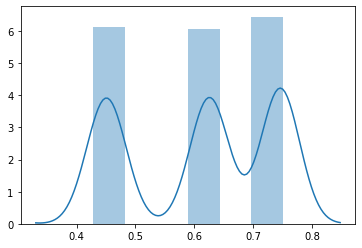

In [5]:
sns.distplot(corrs_raters)

In [6]:
# compute the cumulative mean of human scores
df_agg = df[human_columns].expanding(min_periods=1, axis=1).mean()

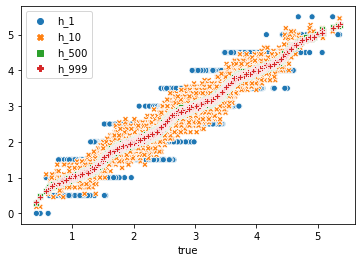

In [7]:
# plot mean scores against true scores for a few key points.
# We set the index to true scores to have them plotted as x-axis
df_agg.index = df['true']
sns.scatterplot(data=df_agg[['h_1', 'h_10', 'h_500', 'h_999']])

In [8]:
# compute correlations with aggregated scores
df_agg.index=df.index
corrs_mean = df_agg.corrwith(df['system'])
corrs_mean.index=range(0, 1000)

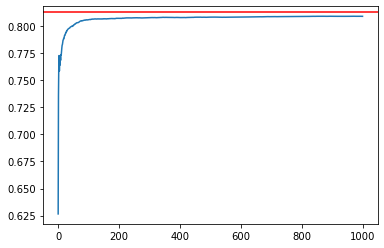

In [9]:
# plot correlations
ax = sns.lineplot(data=corrs_mean)
ax.axhline(true_corr, color='red')

In [10]:
# print correlations for few key steps
df_corrs = pd.DataFrame(corrs_mean).transpose()
df_corrs['true'] = true_corr
df_corrs[[1, 5,  10, 100, 500, 999, 'true']]

,1,5,10,100,500,999,true
0,0.735665,0.768362,0.77288,0.805681,0.808047,0.808799,0.812705
